<a href="https://colab.research.google.com/github/melissamelton/GSB521_CongressionalData/blob/main/Assignment_1b_US_Districts_Bachelors_Degrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from urllib.request import urlopen
import seaborn as sns

In [ ]:
# We are reading in the data we want from ACS 2021. The API returns json data.
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,C15010_001E,C15010_002E,C15010_003E,C15010_004E,C15010_005E,C15010_006E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0)

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Total','Total Science and Engineering', 'Total Science and Engineering Related', 'Total Business', 'Total Education', 'Total Arts, Humanities, and Other', 'State Code', 'District Number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['District Number'] = pd.to_numeric(acs_df['District Number'])

acs_df['State'] = acs_df['State'].str.strip()

# Keep only the columns we need
acs_df = acs_df[['Total', 'Total Science and Engineering', 'Total Science and Engineering Related', 'Total Business', 'Total Education', 'Total Arts, Humanities, and Other', 'District Number', 'State']]

acs_df.head()

,Total,Total Science and Engineering,Total Science and Engineering Related,Total Business,Total Education,"Total Arts, Humanities, and Other",District Number,State
0,129813,36613,13261,31155,22498,26286,1,Alabama
1,109507,34024,9084,25512,17721,23166,2,Alabama
2,126350,34503,16188,26092,21026,28541,3,Alabama
3,95245,24447,11817,19841,20422,18718,4,Alabama
4,193261,79051,15525,40084,23294,35307,5,Alabama


In [ ]:
# Convert number columns to numeric data types
cols = ['Total', 'Total Science and Engineering', 'Total Science and Engineering Related', 'Total Business', 'Total Education', 'Total Arts, Humanities, and Other']
acs_df['Total'] = pd.to_numeric(acs_df['Total'])
acs_df['Total Science and Engineering'] = pd.to_numeric(acs_df['Total Science and Engineering'])
acs_df['Total Science and Engineering Related'] = pd.to_numeric(acs_df['Total Science and Engineering Related'])
acs_df['Total Business'] = pd.to_numeric(acs_df['Total Business'])
acs_df['Total Education'] = pd.to_numeric(acs_df['Total Education'])
acs_df['Total Arts, Humanities, and Other'] = pd.to_numeric(acs_df['Total Arts, Humanities, and Other'])

# Create new columns representing percentage of total
acs_df['% Science and Engineering'] = (100*acs_df['Total Science and Engineering'])/acs_df['Total']
acs_df['% Science and Engineering Related'] = (100*acs_df['Total Science and Engineering Related'])/acs_df['Total']
acs_df['% Business'] = (100*acs_df['Total Business'])/acs_df['Total']
acs_df['% Education'] = (100*acs_df['Total Education'])/acs_df['Total']
acs_df['% Arts, Humanities, and Other'] = (100*acs_df['Total Arts, Humanities, and Other'])/acs_df['Total']

acs_df.head()

,Total,Total Science and Engineering,Total Science and Engineering Related,Total Business,Total Education,"Total Arts, Humanities, and Other",District Number,State,% Science and Engineering,% Science and Engineering Related,% Business,% Education,"% Arts, Humanities, and Other"
0,129813,36613,13261,31155,22498,26286,1,Alabama,28.204417,10.215464,23.999908,17.331084,20.249128
1,109507,34024,9084,25512,17721,23166,2,Alabama,31.070160,8.295360,23.297141,16.182527,21.154812
2,126350,34503,16188,26092,21026,28541,3,Alabama,27.307479,12.812030,20.650574,16.641076,22.588841
3,95245,24447,11817,19841,20422,18718,4,Alabama,25.667489,12.406950,20.831540,21.441545,19.652475
4,193261,79051,15525,40084,23294,35307,5,Alabama,40.903752,8.033178,20.740863,12.053130,18.269077


In [ ]:
# Keep only data related to district number, state, and percentages
cols = ['District Number', 'State', '% Science and Engineering', '% Science and Engineering Related',
        '% Business', '% Education', '% Arts, Humanities, and Other']
acs_df = acs_df[cols]
acs_df.head()

,District Number,State,% Science and Engineering,% Science and Engineering Related,% Business,% Education,"% Arts, Humanities, and Other"
0,1,Alabama,28.204417,10.215464,23.999908,17.331084,20.249128
1,2,Alabama,31.070160,8.295360,23.297141,16.182527,21.154812
2,3,Alabama,27.307479,12.812030,20.650574,16.641076,22.588841
3,4,Alabama,25.667489,12.406950,20.831540,21.441545,19.652475
4,5,Alabama,40.903752,8.033178,20.740863,12.053130,18.269077


Read in the party affiliation data and prepare to merge it with the ACS data.

In [ ]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['District Number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['District Number'] = party_df['District Number'].fillna(0)
party_df['District Number'] = pd.to_numeric(party_df['District Number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "District Number"]]

party_df.head(5)

,State,Party,District Number
0,Louisiana,R,5
1,North Carolina,D,12
2,Alabama,R,4
3,California,D,31
4,Georgia,R,12


Merge the ACS and party dataframes by state and district number.

In [ ]:
merged_df = pd.merge(acs_df, party_df, on= ['State', 'District Number'])
merged_df.head()

,District Number,State,% Science and Engineering,% Science and Engineering Related,% Business,% Education,"% Arts, Humanities, and Other",Party
0,1,Alabama,28.204417,10.215464,23.999908,17.331084,20.249128,R
1,2,Alabama,31.070160,8.295360,23.297141,16.182527,21.154812,R
2,3,Alabama,27.307479,12.812030,20.650574,16.641076,22.588841,R
3,4,Alabama,25.667489,12.406950,20.831540,21.441545,19.652475,R
4,5,Alabama,40.903752,8.033178,20.740863,12.053130,18.269077,R


In [ ]:
merged_df['Party'].value_counts()

D    233
R    201
L      1
Name: Party, dtype: int64

Since there's only one libertarian district, and our plot will be grouped by party, we will remove the libertarian district from the dataset.

In [ ]:
merged_df = merged_df[merged_df['Party'] != 'L']

D    233
R    201
Name: Party, dtype: int64

In [ ]:
df_melt = merged_df.melt(id_vars = 'Party',
                         value_vars = ['% Science and Engineering', 
                                       '% Science and Engineering Related',
                                       '% Business', '% Education', 
                                       '% Arts, Humanities, and Other'],
        var_name = 'columns')

df_melt.head()

,Party,columns,value
0,R,% Science and Engineering,28.204417
1,R,% Science and Engineering,31.070160
2,R,% Science and Engineering,27.307479
3,R,% Science and Engineering,25.667489
4,R,% Science and Engineering,40.903752


[Text(0, 0.5, 'Percentage of 25+ Population'),
 Text(0.5, 0, 'Bachelors Degree Field'),
 Text(0.5, 1.0, 'Boxplot of Percentage of Bachelors Degrees in Various Fields\n Among Republican and Democrat Districts')]

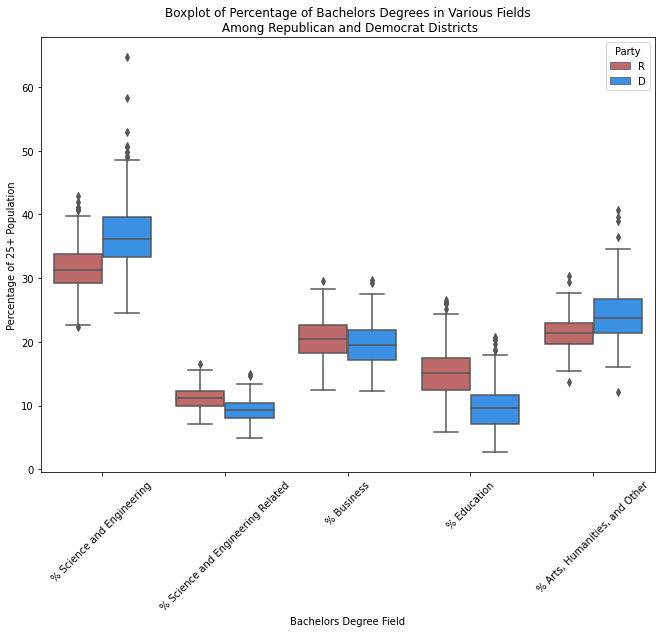

In [ ]:
palette = {'R': 'indianred', 
           'D': 'dodgerblue'}

plt.figure(figsize=(11, 8))

bplot = sns.boxplot(data= df_melt, hue = 'Party', x = 'columns', y = 'value', palette = palette)

plt.xticks(rotation = 45)

bplot.set(xlabel = 'Bachelors Degree Field',
          ylabel = 'Percentage of 25+ Population',
          title = 'Boxplot of Percentage of Bachelors Degrees in Various Fields\n Among Republican and Democrat Districts')